# 1. Data Loading and Preprocessing
In this section, we load the Pima Indians Diabetes dataset and split it into two main parts:

Features (X) and Target (y), where X includes all the features excluding the target variable 'Outcome', and y is the target variable indicating whether the patient has diabetes (1) or not (0).
Standardizing the data ensures that the features are on the same scale, which helps improve the performance of machine learning models.
The dataset is then split into training (80%) and test (20%) sets using train_test_split.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('./data/diabetes.csv')

# Split the features (X) and target label (y)
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training (80%) and testing (20%) sets
X_train_all, X_test, y_train_all, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print('training data has %d observation with %d features'% X_train_all.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 614 observation with 8 features
test data has 154 observation with 8 features


# 2. Standard Random Forest Model Training
Here, we train a standard Random Forest classifier on the full training set. The accuracy of the model on the test set is computed and printed. The result shows an accuracy of 0.7273 for the standard Random Forest model. This serves as a baseline performance to compare against the active learning approach later.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest classifier
rf_standard = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the entire training set (standard approach)
rf_standard.fit(X_train_all, y_train_all)

# Predict on the test set
y_test_pred_standard = rf_standard.predict(X_test)

# Calculate the accuracy of the standard Random Forest
accuracy_standard = accuracy_score(y_test, y_test_pred_standard)
print(f"Random Forest Test Accuracy (Standard Training): {accuracy_standard:.4f}")


Random Forest Test Accuracy (Standard Training): 0.7273


# 3. Active Learning with Random Forest
This section demonstrates the active learning process. Initially, only 5 samples are labeled, and the rest are left unlabeled. We then perform 10 iterations of active learning:

In each iteration, the model is trained on the labeled set, and its performance on the test set is evaluated.
The model predicts probabilities for the unlabeled set, identifying the samples with the highest uncertainty (lowest confidence) and adds them to the labeled set for the next iteration.
The process continues, with the total number of labeled samples increasing by 10 in each iteration.
From the results, we observe that the accuracy improves progressively with each iteration, reaching a final accuracy of 0.7403 after 10 iterations.

In [15]:
# Initialize a small labeled set (only 5 samples), the rest as the unlabeled set
initial_train_size = 5
X_train_labeled = X_train_all[:initial_train_size]
y_train_labeled = y_train_all[:initial_train_size]

X_train_unlabeled = X_train_all[initial_train_size:]
y_train_unlabeled = y_train_all[initial_train_size:]

# Convert y_train_unlabeled to NumPy array to avoid indexing issues
y_train_unlabeled = np.array(y_train_unlabeled)

# Define the number of samples to add in each iteration
n_samples_to_add = 10
total_samples_used = initial_train_size  # Initialize with the size of the initial labeled set

# Initialize Random Forest classifier for Active Learning
rf_active = RandomForestClassifier(n_estimators=100, random_state=42)

# Store accuracies from each iteration for plotting
active_learning_accuracies = []

# Active Learning iterations
for iteration in range(10):  # 10 iterations
    # Train the model on the labeled set
    rf_active.fit(X_train_labeled, y_train_labeled)

    # Validate on the test set
    y_test_pred_active = rf_active.predict(X_test)
    accuracy_active = accuracy_score(y_test, y_test_pred_active)
    active_learning_accuracies.append(accuracy_active)
    
    print(f"Iteration {iteration + 1}: Active Learning Test Accuracy = {accuracy_active:.4f}")

    # Predict on the unlabeled set, get the predicted probabilities
    probabilities = rf_active.predict_proba(X_train_unlabeled)
    
    # Calculate the maximum probability -- the model's most uncertain predictions
    confidence = np.max(probabilities, axis=1)
    
    # Find the most uncertain samples (with the lowest probability) and add them to the labeled set
    least_confident_indices = np.argsort(confidence)[:n_samples_to_add]
    
    # Add the most uncertain samples from the unlabeled set to the labeled set
    X_train_labeled = np.vstack((X_train_labeled, X_train_unlabeled[least_confident_indices]))
    y_train_labeled = np.concatenate((y_train_labeled, y_train_unlabeled[least_confident_indices]))

    # Remove these samples from the unlabeled set
    X_train_unlabeled = np.delete(X_train_unlabeled, least_confident_indices, axis=0)
    y_train_unlabeled = np.delete(y_train_unlabeled, least_confident_indices, axis=0)

    # Update the total number of samples used
    total_samples_used += n_samples_to_add

# Final validation on the test set
final_accuracy_active = accuracy_score(y_test, rf_active.predict(X_test))
print(f"Final Active Learning Test Accuracy: {final_accuracy_active:.4f}")

# Display the total number of samples used in Active Learning
print(f"Total samples used in Active Learning: {total_samples_used}")


Iteration 1: Active Learning Test Accuracy = 0.5390
Iteration 2: Active Learning Test Accuracy = 0.6818
Iteration 3: Active Learning Test Accuracy = 0.7013
Iteration 4: Active Learning Test Accuracy = 0.7532
Iteration 5: Active Learning Test Accuracy = 0.7403
Iteration 6: Active Learning Test Accuracy = 0.7857
Iteration 7: Active Learning Test Accuracy = 0.7727
Iteration 8: Active Learning Test Accuracy = 0.7597
Iteration 9: Active Learning Test Accuracy = 0.7727
Iteration 10: Active Learning Test Accuracy = 0.7403
Final Active Learning Test Accuracy: 0.7403
Total samples used in Active Learning: 105


# 4. Visualization of Accuracy Comparison
This section visualizes the accuracy comparison between the standard Random Forest model and the active learning model across multiple iterations. The plot demonstrates a noticeable improvement in accuracy with active learning, particularly in the first 6 iterations. After 10 iterations, using a total of 105 samples, the active learning model stabilizes around an accuracy of 0.74. In contrast, the standard Random Forest model's accuracy remains constant, using the entire labeled dataset of 614 samples. The plot also annotates the number of samples used at each iteration of active learning, and the total number of samples used by the end of the active learning process is displayed.

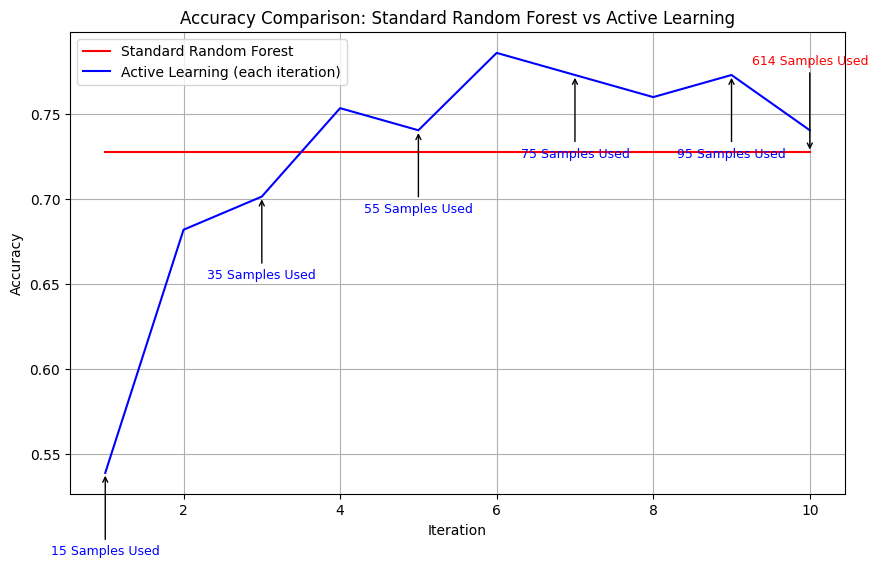

In [16]:
# Plot the accuracy comparison between Standard Random Forest and Active Learning
plt.figure(figsize=(10, 6))

# Create a list of length 10 with all values as accuracy_standard to match the length of active_learning_accuracies
standard_accuracy_line = [accuracy_standard] * len(active_learning_accuracies)

# Plot the standard Random Forest accuracy using a red solid line
plt.plot(range(1, len(active_learning_accuracies) + 1), standard_accuracy_line, 'r', label="Standard Random Forest")

# Plot the accuracy of Active Learning after each iteration using a blue line
plt.plot(range(1, len(active_learning_accuracies) + 1), active_learning_accuracies, 'b', label="Active Learning (each iteration)")

# Annotate the sample usage at each iteration
for i in range(0, len(active_learning_accuracies), 2):  # Show sample usage every two iterations to avoid clutter
    total_samples = initial_train_size + (i + 1) * n_samples_to_add  # Number of samples added in each iteration
    plt.annotate(f'{total_samples} Samples Used', 
                 xy=(i + 1, active_learning_accuracies[i]), 
                 xytext=(i + 1, active_learning_accuracies[i] - 0.05),  # Adjust text position to avoid overlap
                 arrowprops=dict(facecolor='blue', arrowstyle="->"),
                 fontsize=9, 
                 verticalalignment='bottom', 
                 horizontalalignment='center', 
                 color='blue')  # Set the text color to blue

# Annotate the total samples used by the Standard Random Forest (fixed to the full training set size)
plt.annotate(f'{len(X_train_all)} Samples Used', 
             xy=(len(active_learning_accuracies), accuracy_standard), 
             xytext=(len(active_learning_accuracies), accuracy_standard + 0.05),  # Adjust text position
             arrowprops=dict(facecolor='red', arrowstyle="->"),
             fontsize=9, 
             verticalalignment='bottom', 
             horizontalalignment='center', 
             color='red')  # Set the text color to red

# Add labels and title to the plot
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Standard Random Forest vs Active Learning")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


# 5. Summary for Active Learning Part
he standard Random Forest classifier achieved an accuracy of 0.7273 on the test set when trained using the full dataset. However, the active learning approach showed significant improvement in accuracy over time. Initially, with just 5 labeled samples, the accuracy started at 0.5390 but progressively improved with each iteration. By the 10th iteration, the accuracy reached 0.7403.

Active learning enabled the model to strategically select and add the most uncertain samples to the training set, resulting in enhanced performance. By the end of the process, the model utilized a total of 105 labeled samples, demonstrating the efficiency of active learning in improving model accuracy with fewer labeled data.